<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew.

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [568]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

%matplotlib inline

### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [569]:
# ANSWER
titanic_csv = r'C:\Users\Vinitha\Desktop\IOD\DATA\titanic_train.csv'
df = pd.read_csv(titanic_csv)

Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

Explore dataset. Find features to predict `Survived`. Get rid of null values.

In [570]:
#head
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [571]:
#tail
df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [572]:
#shape
df.shape

(891, 12)

In [573]:
#find null values
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [574]:
#type
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [575]:
#fill age with median
df['Age'].fillna(df.groupby( ['Sex'])['Age'].transform("median"), inplace = True)

C:\Users\Vinitha\AppData\Local\Temp\ipykernel_24472\3662555920.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df.groupby( ['Sex'])['Age'].transform("median"), inplace = True)


In [576]:
#removing column 'unnamed'
df = df.drop(columns = ['Cabin', 'Name', 'Sex'])
df.head(1)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,22.0,1,0,A/5 21171,7.25,S


In [577]:
#describe
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.441268,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.018747,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,29.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [578]:
#Mapping dictionary
bm_map = {
    'S': 1,
    'C': 2,
    'Q': 3
}
df['Embarked'] = df["Embarked"].map(bm_map)

In [579]:
#filling null
embarked_mode = df['Embarked'].mode()[0]
df['Embarked'].fillna(embarked_mode, inplace=True)

C:\Users\Vinitha\AppData\Local\Temp\ipykernel_24472\2509025219.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Embarked'].fillna(embarked_mode, inplace=True)


In [580]:
# Check if NaN values are filled
df['Embarked'].isna().sum()

0

In [581]:
#correlation on numeric features
numeric_df = df.select_dtypes(include='number')
correlation_matrix = numeric_df.corr()

In [582]:
#correlation on numeric features
numeric_df.corr().T

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked
PassengerId,1.000000,-0.005007,-0.035144,0.035734,-0.057527,-0.001652,0.012658,-0.030467
Survived,-0.005007,1.000000,-0.338481,-0.073296,-0.035322,0.081629,0.257307,0.106811
Pclass,-0.035144,-0.338481,1.000000,-0.338056,0.083081,0.018443,-0.549500,0.045702
Age,0.035734,-0.073296,-0.338056,1.000000,-0.236376,-0.176038,0.094161,-0.010477
SibSp,-0.057527,-0.035322,0.083081,-0.236376,1.000000,0.414838,0.159651,-0.059961
Parch,-0.001652,0.081629,0.018443,-0.176038,0.414838,1.000000,0.216225,-0.078665
Fare,0.012658,0.257307,-0.549500,0.094161,0.159651,0.216225,1.000000,0.062142
Embarked,-0.030467,0.106811,0.045702,-0.010477,-0.059961,-0.078665,0.062142,1.000000


In [583]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

### 3. Numerical Predictors Only

#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [584]:
from sklearn.preprocessing import LabelEncoder

In [585]:
label_encoder = LabelEncoder()
df['Ticket'] = label_encoder.fit_transform(df['Ticket'])

In [586]:
# Prepare features and target variable
features = ['Pclass', 'Parch'] # Assign 'Pclass' and 'Parch' column as the feature variable
X = df[features]
y = df['Survived']  # Assign 'Survived' column as the target variable

#### 3.2 Split

Split the data into training and testing subsets:

- Use `random_state` = 1

In [587]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [588]:
# Create Model
# Initialize and train the model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=2000)

Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [589]:
# ANSWER
# Fit Model
model.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [590]:
y_train_pred = model.predict(X_train)

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [591]:
#Coefficients and feature names
coefficients = pd.DataFrame({"Variable": X.columns, "Coefficient": model.coef_[0]})
print(coefficients)

  Variable  Coefficient
0   Pclass    -0.908234
1    Parch     0.334253


The computed intercept (`intercept_`) is the 1st element of another array:

In [592]:
# ANSWER
intercept = model.intercept_
print(f"Intercept: {intercept}")

Intercept: [1.40834635]


We can create tuples of the predictor names and coefficients like this:

In [593]:
feature_cols = ['PassengerId', 'Survived', 'Age', 'SibSp', 'Ticket', 'Fare', 'Embarked'] 

In [594]:
# predictor names and coefficients
print(set(zip(feature_cols, model.coef_[0])))

{('PassengerId', -0.9082343762695314), ('Survived', 0.334252887891543)}


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [595]:
for col in zip(X_train.columns, model.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

Pclass      -0.908234
Parch       +0.334253


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The accuracy `score` is the proportion of correct predictions:

In [596]:
# accuracy score(train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

Training Accuracy: 0.6924


What is the accuracy `score` for the test data?

In [597]:
# accuracy score(test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.1620


What can we say about this result?

ANSWER
- The model is likely overfitting the training data. This means that it is capturing noise or random fluctuations in the training data.
- A test accuracy of 0.1620 indicates that only about 16.20% of the predictions made by the model on the test data match the actual labels.

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

In [598]:
# ANSWER
features = ['Pclass', 'Parch', 'Age']
target = 'Survived'

X = df[features]
y = df[target]

In [599]:
# Build Model
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Creating a logistic regression model
model = LogisticRegression()

# Fit Model
model.fit(X_train, y_train)

LogisticRegression()

In [600]:
# Training the model
y_pred = model.predict(X_test)

In [601]:
# Score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.76


So, including age did little to reduce the variance in our model. Why might this be?

ANSWER

- Age may not have a strong correlation with the target variable (Survived).
- Adding Age as a feature in your logistic regression model increased the overall accuracy significantly.
- Adding Age may not provide much additional explanatory power or variance reduction.

Let's see where the model is going wrong by showing the Confusion Matrix:

In [602]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [603]:
# ANSWER
print(confusion_matrix(y_test, y_pred))

[[94 11]
 [32 42]]


Nb. Here is how `confusion_matrix` arranges its output:

In [604]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


Which type of error is more prevalent?

ANSWER: ...

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

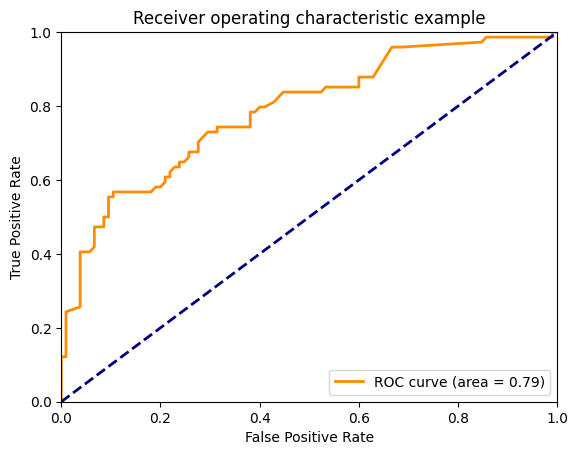

In [605]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = model.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [651]:
# ANSWER
titanic_csv = r'C:\Users\Vinitha\Desktop\IOD\DATA\titanic_train.csv'
titanic_with_dummies = pd.read_csv(titanic_csv)

In [652]:
titanic_with_dummies.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [653]:
# Convert categorical variables to dummy variables
titanic_with_dummies = pd.get_dummies(titanic_with_dummies, columns=['Sex', 'Pclass'], drop_first=True)

In [654]:
titanic_with_dummies.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_male,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,True,False,True
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,False,False,False
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,False,True
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,False,False,False
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,True,False,True


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first variable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [655]:
# Impute missing Age values based on Sex and Pclass groups
titanic_with_dummies['Age'] = titanic_with_dummies.groupby(['Sex_male', 'Pclass_2', 'Pclass_3'])['Age'].transform(lambda x: x.fillna(x.mean()))

Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [656]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [657]:
# ANSWER
# Selecting features and target variable
features = ["Parch", "Sex_male", "Pclass_2", "Pclass_3", "Age"] # Set Feature Both Numerical, Categorical
target = "Survived"

# Extracting features and target variable
X = titanic_with_dummies[features]
y = titanic_with_dummies[target]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [658]:
#fit model
model.fit(X_train, y_train)

LogisticRegression()

In [659]:
# Probability of positive class
y_prob = model.predict_proba(X_test)[:, 1]  

Plot the ROC curve for the new model:

In [660]:
# ANSWER
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

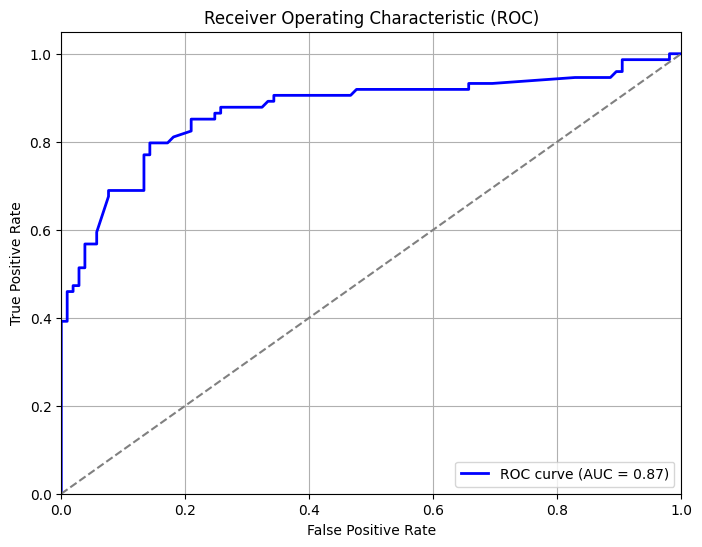

In [661]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Can we improve the model by including the remaining features?

In [665]:
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Sex_male', 'Pclass_2', 'Pclass_3'],
      dtype='object')

In [666]:
df.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_male,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,True,False,True
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,False,False,False
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,False,True
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,False,False,False
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,True,False,True


In [669]:
# Selecting features and target variable
features = ["Age", "SibSp", "Parch", "Fare"] # Set Feature Both Numerical, Categorical
target = "Survived"

# Extracting features and target variable
X = titanic_with_dummies[features]
y = titanic_with_dummies[target]

In [670]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [671]:
#fit model
model.fit(X_train, y_train)

LogisticRegression()

In [672]:
# Probability of positive class
y_prob = model.predict_proba(X_test)[:, 1]  

In [673]:
# ANSWER
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

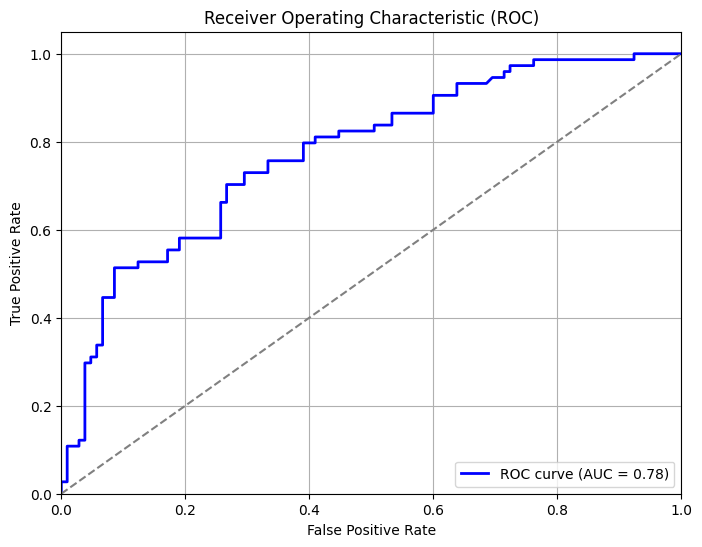

In [674]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.



---



---



> > > > > > > > > © 2024 Institute of Data


---



---



